In [3]:
import json
import pandas as pd
from collections import deque
from elasticsearch import Elasticsearch
from elasticsearch.helpers import parallel_bulk
import cv2
from matplotlib import pyplot as plt
import spacy
from spacy import displacy
from spacy.matcher import Matcher
nlp = spacy.load("en_core_web_sm")

In [2]:
from elasticsearch import helpers
client = Elasticsearch(
    "http://localhost:9200",
     basic_auth=("elastic", "elastic")

)
resp = client.info()

In [3]:
with open('captions\\annotations\captions_val2014.json', 'r') as f:
    data = json.load(f);

anno_df = pd.DataFrame(data['annotations'])

In [33]:
doc_setting = {
  
        "analysis": {
            "analyzer": {
                "my_analyzer_keyword": {
                    "type": "custom",
                    "tokenizer": "keyword",
                    "filter": [
                        "asciifolding",
                        "lowercase",
                        "stemmer"
                    ]
                },
                "my_analyzer_shingle": {
                    "type": "custom",
                    "tokenizer": "standard",
                    "filter": [
                        "asciifolding",
                        "lowercase",
                        "stemmer"
                    ]
                }
            },
        }
   
}

mappings = {
  
   
            "properties": {
                'id':{
                    'type': "integer"
                },
                "caption": {
                    "type": "text",
                    "analyzer": "my_analyzer_shingle",
                    "search_analyzer": "my_analyzer_shingle"
                },
                 "image_id": {"type": "integer"},
            }
        
    
}

In [35]:
client.indices.delete(index='cocomo')

ObjectApiResponse({'acknowledged': True})

In [36]:
client.indices.create(index='cocomo',settings= doc_setting,mappings=mappings)


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'cocomo'})

In [35]:
all = client.search(index="testcocomo22", query={"match_all": {}})
print("Got %d Hits:" % all['hits']['total']['value'])
for hit in all['hits']['hits']:
    print("%(caption)s %(image_id)s: %(id)s" % hit["_source"])

Got 11 Hits:
A bicycle replica with a clock as the front wheel. 203564: 37
A black Honda motorcycle parked in front of a garage. 179765: 38
A room with blue walls and a white sink and door. 322141: 49
A car that seems to be parked illegally behind a legally parked car 16977: 89
A large passenger airplane flying through the air. 106140: 98
There is a GOL plane taking off in a partly cloudy sky. 106140: 101
Blue and white color scheme in a small bathroom. 322141: 109
This is a blue and white bathroom with a wall sink and a lifesaver on the wall. 322141: 121
A blue boat themed bathroom with a life preserver on the wall 322141: 163
The bike has a clock as a tire. 203564: 181


In [37]:
def gendata():
    i = 0
    for rec in data['annotations']:
        yield {
            "_index": 'cocomo',
            "_source": rec
        }
        if(i>200000):
            break
        

pb = parallel_bulk(client, gendata(), 
                    chunk_size=10000, thread_count=16, queue_size=16)
deque(pb, maxlen=0)

deque([])

In [38]:
all = client.search(index="cocomo", query={"match_all": {}})
print(all['hits'])
# print("Got %d Hits:" % all['hits']['total'])
# for hit in all['hits']['hits']:
#     print("%(caption)s %(image_id)s: %(id)s" % hit["_source"])

{'total': {'value': 10000, 'relation': 'gte'}, 'max_score': 1.0, 'hits': [{'_index': 'cocomo', '_id': 'd5XugIEBXybHSoPEFVrA', '_score': 1.0, '_source': {'image_id': 203564, 'id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.'}}, {'_index': 'cocomo', '_id': 'eJXugIEBXybHSoPEFVrA', '_score': 1.0, '_source': {'image_id': 179765, 'id': 38, 'caption': 'A black Honda motorcycle parked in front of a garage.'}}, {'_index': 'cocomo', '_id': 'eZXugIEBXybHSoPEFVrA', '_score': 1.0, '_source': {'image_id': 322141, 'id': 49, 'caption': 'A room with blue walls and a white sink and door.'}}, {'_index': 'cocomo', '_id': 'epXugIEBXybHSoPEFVrA', '_score': 1.0, '_source': {'image_id': 16977, 'id': 89, 'caption': 'A car that seems to be parked illegally behind a legally parked car'}}, {'_index': 'cocomo', '_id': 'e5XugIEBXybHSoPEFVrA', '_score': 1.0, '_source': {'image_id': 106140, 'id': 98, 'caption': 'A large passenger airplane flying through the air.'}}, {'_index': 'cocomo', '_id': 

In [7]:
query = {
            "match": {
            "caption": " united states"
            }
        }
image_ids =[]
image_caption =[]
resp = client.search(index="cocomo", query=query)
print("Got %d Hits:" % resp['hits']['total']['value'])
for hit in resp['hits']['hits']:
  
    image_ids.append(hit['_source']['image_id'])
    image_caption.append(hit['_source']['caption'])
print(image_caption)

Got 160 Hits:
['A United States air plane taking off .', 'A motorcycle with United States Marine Corp markings.', 'A row of United States Army military fighter jets.', 'A cake designed to resemble the united states flag', 'The President of the United States giving a stirring speech.', 'The president of the United States walking beside a building.', 'A raised United States of America flag on a pole', 'A kite flying over a large flying united states flag.', 'an image of the president of the united states of America\n', 'The president of the United States pointing behind him during a speech.']


In [5]:
class sys:
    def __init__(self):
        self.image_ids =[]
        self.image_caption =[]

    def search(self,query):
        self.image_ids =[]
        self.image_caption =[]
        query = {
            "match": {
            "caption": query
            }
        }
        resp = client.search(index="cocomo", query=query,size=20)
        print("Got %d Hits:" % resp['hits']['total']['value'])
        for hit in resp['hits']['hits']:
          #  print("%(caption)s : %(image_id)s : %(id)s" % hit["_source"])
            self.image_ids.append(hit['_source']['image_id'])
            self.image_caption.append(hit['_source']['caption'])
        self.display();
        
    def display(self):
        i = 0
        plt.figure(figsize=(25,50))
        columns = 2
        for i, id in enumerate(self.image_ids):
            plt.subplot(10, 3, i + 1)
            path = '..\..\Cocomo2014\\val2014\\val2014\COCO_val2014_'+ '0'*(12 - len(str(id))) + str(id) +'.jpg'
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.title(self.image_caption[i])
            plt.imshow(img)
ir = sys()


Got 10000 Hits:


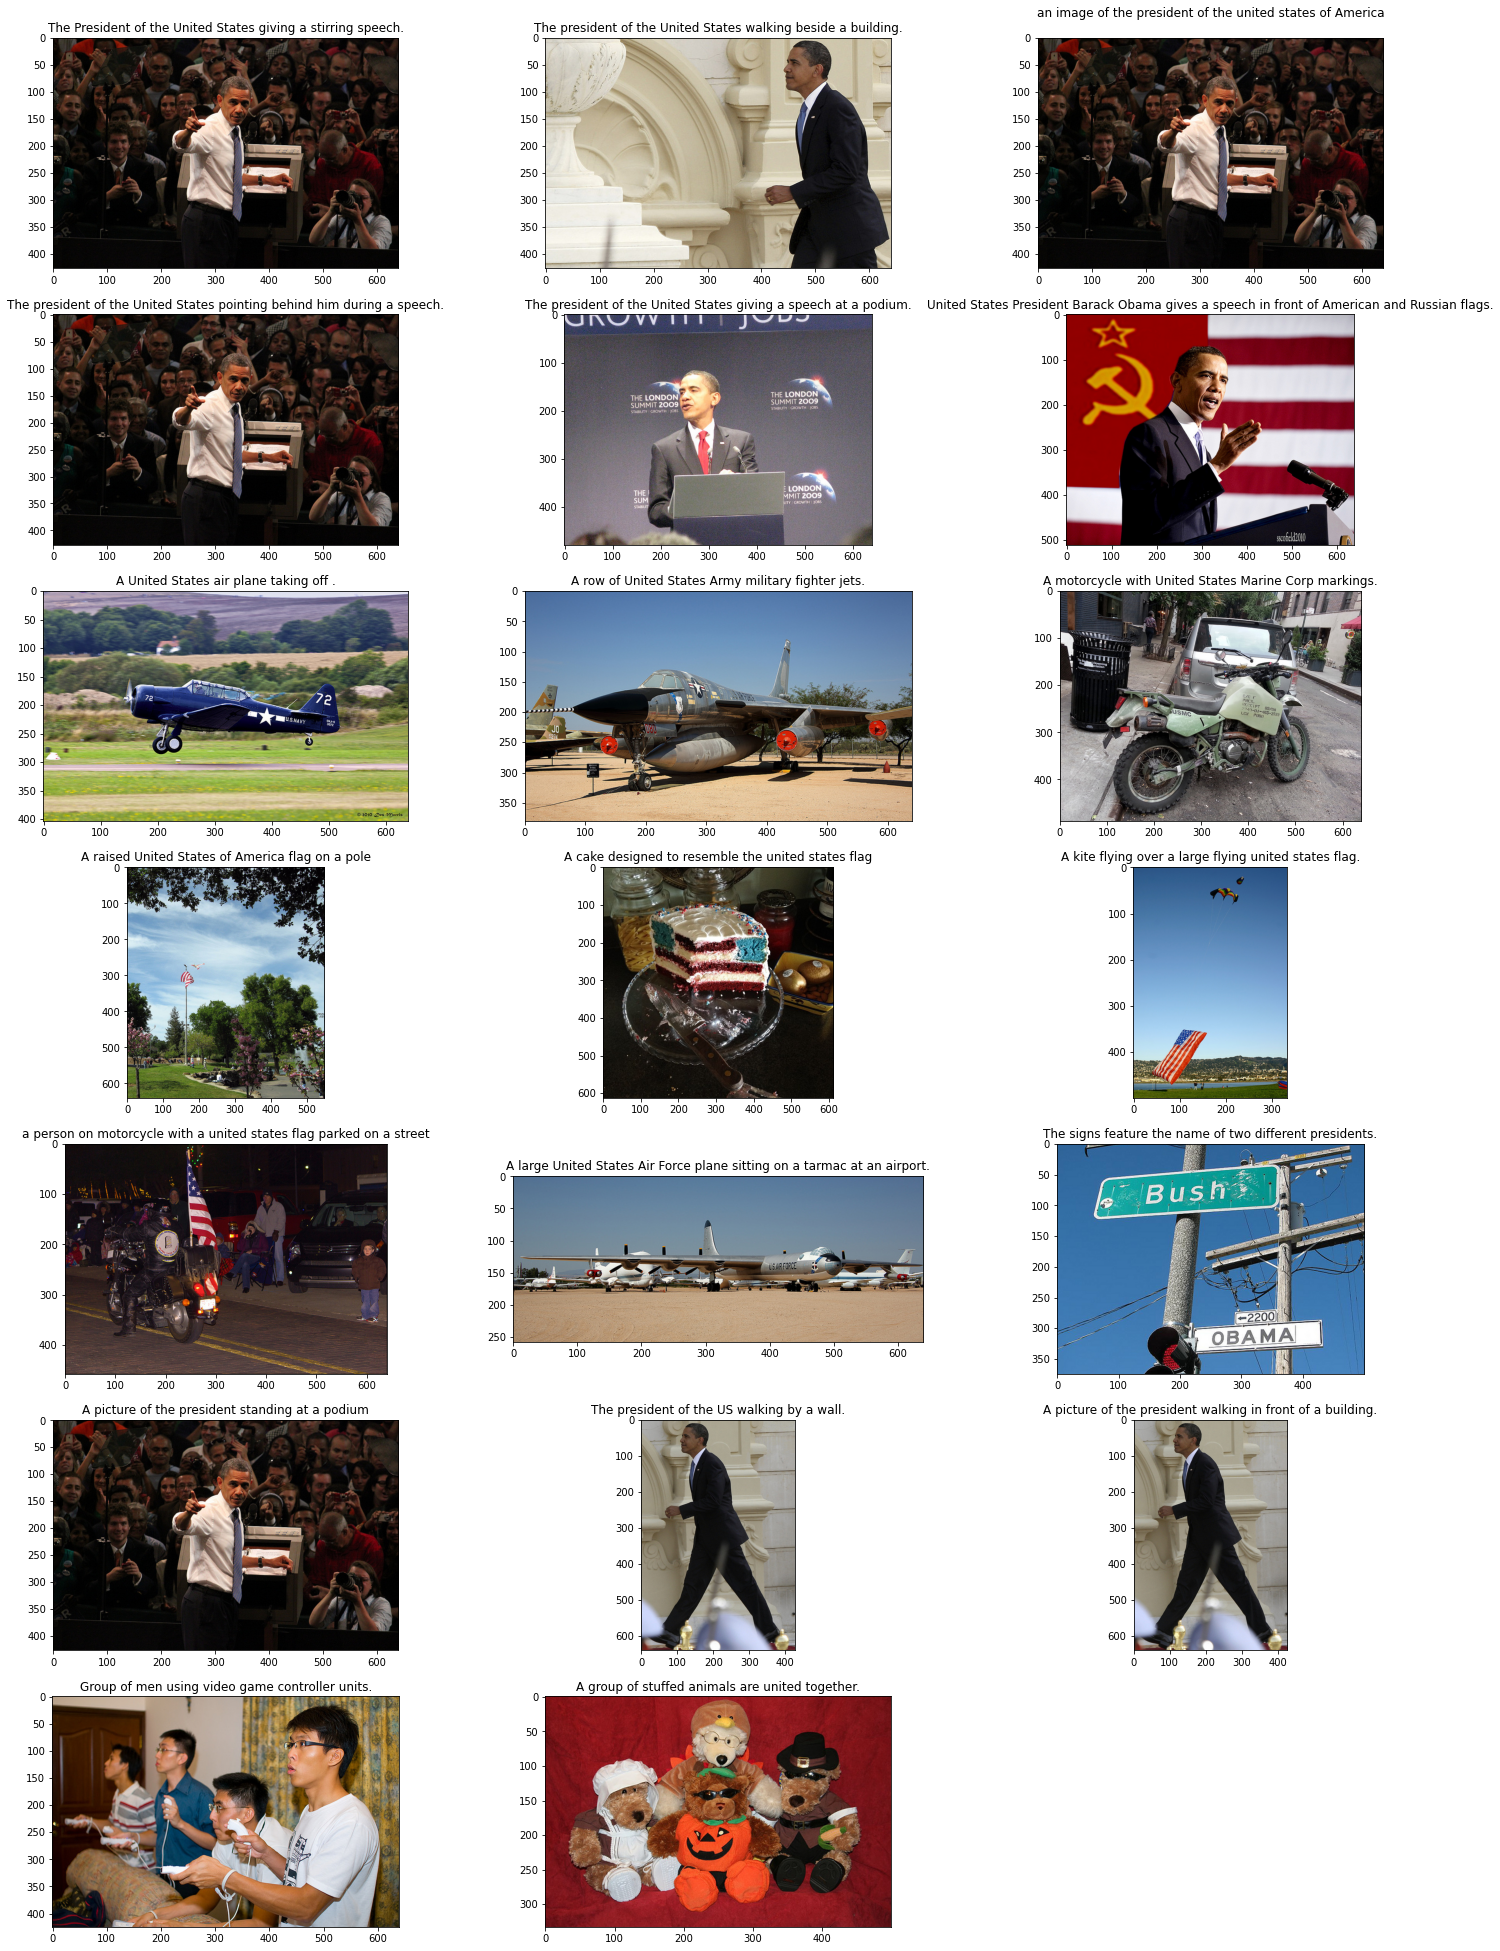

In [6]:
ir.search('president of united states') 

In [9]:
sent = ir.image_caption[0]

In [24]:
nlp.add_pipe("merge_entities")
nlp.add_pipe("merge_noun_chunks")

<function spacy.pipeline.functions.merge_entities(doc: spacy.tokens.doc.Doc)>

In [7]:
doc = nlp(ir.image_caption[5])
print(ir.image_caption[5])
# for ent in doc.ents:
#     print(ent.text, ent.start_char, ent.end_char, ent.label_)

#displacy.serve(doc, style="ent")

for chunk in doc.noun_chunks:
    print(chunk.text)

United States President Barack Obama gives a speech in front of American and Russian flags.
United States President Barack Obama
a speech
front
American and Russian flags


In [4]:
from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab)

In [51]:
doc = nlp("Who is the united states president")
for chunk in doc.noun_chunks:
    print(chunk.text)

Who
the united states president


In [43]:
doc = nlp("Who is mohammad dareer?")
print( [token.pos_ for token in doc])
print( [token.text for token in doc])
for chunk in doc.noun_chunks:
    print(chunk.text)

['PRON', 'AUX', 'PROPN', 'NOUN', 'PUNCT']
['Who', 'is', 'mohammad', 'dareer', '?']
Who
mohammad dareer


In [7]:
doc = nlp("give me photos that contains red color")
print( [token.pos_ for token in doc]) 

['VERB', 'PRON', 'NOUN', 'PRON', 'VERB', 'ADJ', 'NOUN']


In [53]:
with open('questions.json', 'r') as f:
    pat = json.load(f)
print(pat[0]['patterns'][0]['pos'])

['PRON AUX NOUN', 'PRON AUX PROPN', 'PRON AUX PROPN PROPN', 'PRON AUX PROPN NOUN']


In [27]:
texts = [t.text for t in nlp("who is the president of united states of america")]
print(texts)

['who', 'is', 'the', 'president', 'of', 'united states of', 'america']


In [80]:
class question_matcher:
    def __init__(self):
        self.patterns= []
        self.q_json = self.get_questions_json()
        self.matcher = Matcher(nlp.vocab)

    def get_questions_json(self):
        with open('questions.json', 'r') as f:
            pat = json.load(f)
        return pat
    
    def define_keyword(self,question:str):
        for q in self.q_json:
            if q['keyword'] in question.lower():
                keyword = q['keyword']
                index = q['qid']
        return keyword, index

    def match_pattern(self,question):
        keyword, index = self.define_keyword(question)
        for pattern in self.q_json[index]['patterns']:
            pos = self.pattern_to_pos(pattern['pos'])
            i = 0
            
            matcher.remove("0")
            matcher.add('0', pos,on_match=self.on_match)

            doc = nlp(question)
            matches = matcher(doc)
            if matches != []:
                return pattern['pattern']
            else:
                print('fail')


    def on_match(self,matcher, doc, id, matches):
        print('Matched!', matches)

    def pattern_to_pos(self, patterns:list):
        pos = []
        pattern = []
        #print(patterns)
        for p in patterns:
            
            itr = []
            pattern.append(p)
            for token in p.split():
                if token != '*':
                    itr.append({'POS':token})
                else:
                    itr.append({})
            pos.append(itr)
       
        return pos
qm = question_matcher()


In [81]:
qm.match_pattern('give me images that contain color red')

Matched! [(746762829127501960, 0, 6)]


'give me images that contain [ENTITY]'

In [83]:
qm.match_pattern('who is the president of united states')

fail
Matched! [(746762829127501960, 0, 3)]


'who [is,was] [ENTITY]'